In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

df = pd.read_csv(r'D:\H.U.S.T\Machine Learning\MLOps - Copy\data\gspc_raw_data.csv')
df = df[['Close', 'High', 'Low', 'Open']]
df = df.drop(index=[0, 1]).reset_index(drop=True)

def create_sequence(data: pd.DataFrame, seq_length: int):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i + seq_length, :])
        y.append(data.iloc[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 20
num_features = 4
X,y = create_sequence(df, seq_length)
train_size = int(len(df)*0.8)
X_train, X_test = X[0:train_size, :], X[train_size:, :]
y_train, y_test = y[0:train_size], y[train_size:]


scalerX = MinMaxScaler(feature_range =(0,1))
scalery = MinMaxScaler(feature_range = (0,1))

x_train = scalerX.fit_transform(X_train.reshape(-1, num_features*seq_length))
x_test = scalerX.transform(X_test.reshape(-1, num_features*seq_length))
y_train = scalery.fit_transform(y_train.reshape(-1,1))
y_test = scalery.transform(y_test.reshape(-1,1))


x_train = torch.from_numpy(x_train.reshape(-1, seq_length, num_features)).float()
x_test = torch.from_numpy(x_test.reshape(-1, seq_length, num_features)).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()


class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTMModel, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.fc(out[:, -1, :])
    return out
  


def train_model(model, criterion, optimizer, x_train, y_train, epochs=10, batch_size=30):
  model.train()
  for epoch in range(epochs):
    for i in range(0, len(x_train), batch_size):
      x_batch = x_train[i:i+batch_size]
      y_batch = y_train[i:i+batch_size]
      optimizer.zero_grad()
      loss = criterion(model(x_batch),y_batch)
      loss.backward()
      optimizer.step()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
      

def evaluate_model(neurons, opt, x_train, y_train, x_test, y_test, epochs=10, batch_size=30):
  model = LSTMModel(input_size = num_features, hidden_size= neurons, output_size=1)
  criterion = nn.MSELoss()
  if opt == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
  else:
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

  train_model(model, criterion, optimizer, x_train, y_train, epochs=epochs, batch_size=batch_size)
  model.eval()
  with torch.no_grad():
    y_pred = model(x_test)
  mse = criterion(y_test, y_pred)
  return mse, model
    
mse, model = evaluate_model(1000, 'sgd', x_train, y_train, x_test, y_test)



# Dự đoán và vẽ đồ thị
model.eval()
with torch.no_grad():
    y_pred = model(x_test)

mse = mean_squared_error(y_test.numpy(), y_pred.numpy())


torch.save(model.state_dict(), 'lstm_model_gspc.pth')




Epoch [1/10], Loss: 0.0190
Epoch [2/10], Loss: 0.0129
Epoch [3/10], Loss: 0.0087
Epoch [4/10], Loss: 0.0055
Epoch [5/10], Loss: 0.0032
Epoch [6/10], Loss: 0.0018
Epoch [7/10], Loss: 0.0009
Epoch [8/10], Loss: 0.0004
Epoch [9/10], Loss: 0.0002
Epoch [10/10], Loss: 0.0000


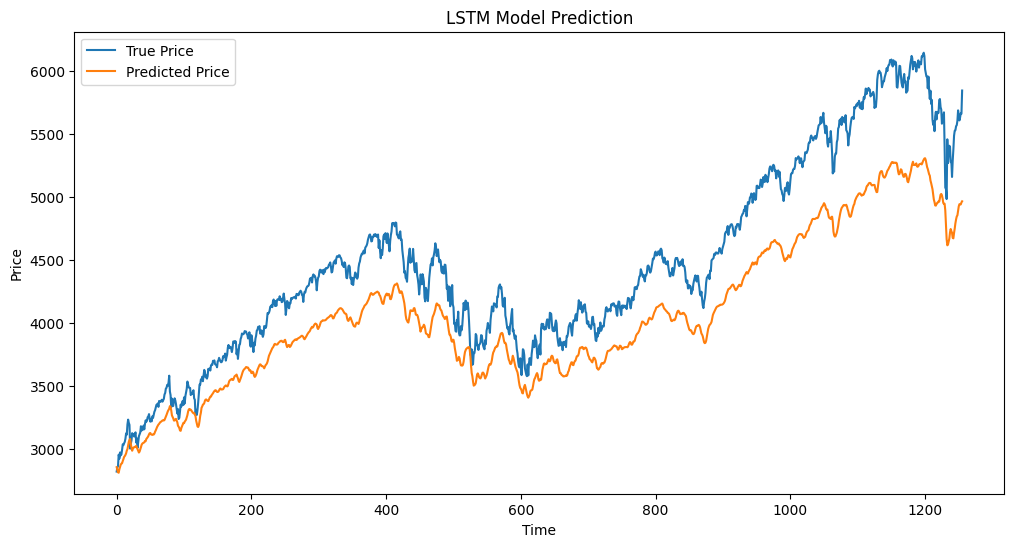

Mean Squared Error: 0.0273


In [2]:
# ve đồ thị
y_test = scalery.inverse_transform(y_test.numpy())
y_pred = scalery.inverse_transform(y_pred.numpy()) 
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Price')
plt.plot(y_pred, label='Predicted Price')
plt.title('LSTM Model Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
print(f'Mean Squared Error: {mse:.4f}')

In [3]:
mse = mean_squared_error(y_test, y_pred)
mse

200490.390625

In [4]:
y_test = scalery.fit(y_test)
y_pred = scalery.fit(y_pred)
mse = mean_squared_error(y_test.numpy(), y_pred.numpy())
mse

AttributeError: 'MinMaxScaler' object has no attribute 'numpy'